In [1]:
%reload_ext autotime
import pandas as pd
import requests
import geopandas as gpd
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map
import time
import os
from glob import glob
from coastsat import SDS_transects
import json
import matplotlib.pyplot as plt
import dotenv
dotenv.load_dotenv()

True

In [2]:
poly = gpd.read_file("polygons.geojson")
poly = poly[poly.id.str.startswith("nzd")]
poly.set_index("id", inplace=True)
poly

,area,id_sorted,northing,geometry
id,,,,
nzd0001,3.069093e+06,nzd0001,-4.085604e+06,"POLYGON ((172.96406 -34.43054, 172.99324 -34.4..."
nzd0002,1.507931e+06,nzd0002,-4.086100e+06,"POLYGON ((172.93456 -34.42857, 172.95856 -34.4..."
nzd0003,2.484730e+06,nzd0003,-4.087232e+06,"POLYGON ((173.0098 -34.42055, 173.00088 -34.44..."
nzd0006,9.619509e+05,nzd0004,-4.090732e+06,"POLYGON ((173.00532 -34.46694, 173.00612 -34.4..."
nzd0007,3.109433e+06,nzd0005,-4.095516e+06,"POLYGON ((172.99847 -34.48102, 173.00081 -34.5..."
...,...,...,...,...
nzd0575,NaN,None,NaN,"POLYGON ((173.18745 -41.2779, 173.12488 -41.25..."
nzd0576,NaN,None,NaN,"POLYGON ((173.01937 -41.02342, 173.02132 -41.0..."
nzd0577,NaN,None,NaN,"POLYGON ((173.01823 -41.03887, 173.02131 -41.0..."


1999-08-17 22:10:00+00:00 POINT (172.97690966086745 -34.42150701355086)


<Axes: xlabel='time'>

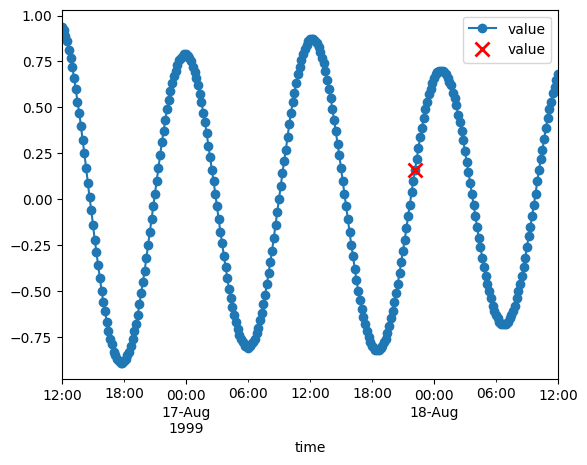

In [3]:
sitename = "nzd0001"
dates = pd.to_datetime(pd.read_csv(f"data/{sitename}/transect_time_series.csv").dates).dt.round("10min")
point = poly.geometry[sitename].centroid
datetime = dates.iloc[0]
print(datetime, point)
r = requests.get("https://api.niwa.co.nz/tides/data", params={
    "lat": point.y,
    "long": point.x,
    "numberOfDays": 2,
    "startDate": str(datetime.date()),
    "datum": "MSL",
    "interval": 10, # 10 minute resolution
    "apikey": os.environ["NIWA_API_KEY"]
}, timeout=(30,30))
df = pd.DataFrame(r.json()["values"])
df.index = pd.to_datetime(df.time)
ax = df.plot(style="o-")
df[df.index == datetime].plot(color="red", style="x", ax=ax, mew=2, ms=10)

In [4]:
datetime, datetime.tz_convert("Pacific/Auckland")

(Timestamp('1999-08-17 22:10:00+0000', tz='UTC'),
 Timestamp('1999-08-18 10:10:00+1200', tz='Pacific/Auckland'))

When I asked for 1 day (1999-08-17), I got 1999-08-16 12:00 - 1999-08-17 12:00. Have to request 2 days, then pull out the one datetime I want

In [3]:
files = pd.DataFrame({"filename": sorted(glob("data/nzd*/transect_time_series.csv"))})
files["sitename"] = files.filename.str.split("/").str[1]
files["have_tides"] = files.sitename.apply(lambda s: os.path.isfile(f"data/{s}/tides.csv"))
files

,filename,sitename,have_tides
0,data/nzd0001/transect_time_series.csv,nzd0001,True
1,data/nzd0002/transect_time_series.csv,nzd0002,True
2,data/nzd0003/transect_time_series.csv,nzd0003,True
3,data/nzd0004/transect_time_series.csv,nzd0004,True
4,data/nzd0005/transect_time_series.csv,nzd0005,True
...,...,...,...
573,data/nzd0575/transect_time_series.csv,nzd0575,True
574,data/nzd0576/transect_time_series.csv,nzd0576,True
575,data/nzd0577/transect_time_series.csv,nzd0577,True
576,data/nzd0578/transect_time_series.csv,nzd0578,True


In [4]:
def get_tide_for_dt(point, datetime):
    while True:
        try:
            r = requests.get("https://api.niwa.co.nz/tides/data", params={
                "lat": point.y,
                "long": point.x,
                "numberOfDays": 2,
                "startDate": str(datetime.date()),
                "datum": "MSL",
                "interval": 10, # 10 minute resolution
                "apikey": os.environ["NIWA_API_KEY"]
            }, timeout=(30,30))
        except Exception as e:
            print(e)
            time.sleep(5)
            continue
        if r.status_code == 200:
            df = pd.DataFrame(r.json()["values"])
            df.index = pd.to_datetime(df.time)
            return df.value[datetime]
        elif r.status_code == 429:
            sleep_seconds = 30
            # sleep for x seconds to refresh the count
            print(f'Num of API reqs exceeded, Sleeping for: {sleep_seconds} seconds...')
            time.sleep(sleep_seconds)

for sitename in tqdm(files[~files.have_tides].sitename):
    dates = pd.to_datetime(pd.read_csv(f"data/{sitename}/transect_time_series.csv").dates).dt.round("10min")
    point = poly.geometry[sitename].centroid

    results = []
    for date in tqdm(dates):
        result = get_tide_for_dt(point, date)
        results.append({
            "dates": date,
            "tide": result
        })
    df = pd.DataFrame(results)
    df.set_index("dates", inplace=True)
    df.to_csv(f"data/{sitename}/tides.csv")

0it [00:00, ?it/s]

In [5]:
files["have_tides"] = files.sitename.apply(lambda s: os.path.isfile(f"data/{s}/tides.csv"))

In [6]:
# Transects, origin is landward. Has beach_slope
transects = gpd.read_file("transects_extended.geojson").to_crs(2193).drop_duplicates(subset="id")
transects.set_index("id", inplace=True)
transects

,site_id,orientation,along_dist,along_dist_norm,beach_slope,cil,ciu,trend,n_points,n_points_nonan,r2_score,mae,mse,rmse,intercept,ERODIBILITY,geometry
id,,,,,,,,,,,,,,,,,
aus0001-0000,aus0001,104.347648,0.000000,0.000000,0.085,0.0545,0.2000,-1.441081,767.0,428.0,0.168420,28.102591,1263.560863,35.546601,179.085729,None,"LINESTRING (-422245.836 7118667.88, -421827.54..."
aus0001-0001,aus0001,93.495734,98.408334,0.002935,0.050,0.0387,0.0640,-1.037105,767.0,569.0,0.097874,25.419324,1033.770813,32.152306,212.247788,None,"LINESTRING (-422256.313 7118525.222, -421837.6..."
aus0001-0002,aus0001,82.069341,198.408334,0.005918,0.050,0.0428,0.0647,-0.680019,767.0,588.0,0.053927,22.632907,838.007507,28.948359,205.106151,None,"LINESTRING (-422219.773 7118383.012, -421816.8..."
aus0001-0003,aus0001,81.192757,298.402523,0.008900,0.055,0.0480,0.0659,-0.405198,767.0,598.0,0.023412,20.749758,698.653187,26.432048,191.745881,None,"LINESTRING (-422187.543 7118279.615, -421786.5..."
aus0001-0004,aus0001,81.065473,398.402523,0.011882,0.075,0.0614,0.0922,-0.090025,767.0,608.0,0.001277,19.889328,655.810616,25.608800,175.092121,None,"LINESTRING (-422155.665 7118178.983, -421754.9..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nzd0579-0000,nzd0579,NaN,NaN,NaN,0.040,0.0381,0.0416,-0.281528,884.0,690.0,0.008935,18.056946,517.647642,22.751871,247.801300,None,"LINESTRING (1603963.61 5467039.521, 1604360.95..."
nzd0579-0001,nzd0579,NaN,NaN,NaN,0.160,0.1280,0.2000,0.189646,884.0,689.0,0.019538,7.332599,103.004296,10.149103,222.459495,None,"LINESTRING (1603955.09 5467142.194, 1604355.09..."
nzd0579-0002,nzd0579,NaN,NaN,NaN,0.200,0.1731,0.2000,0.514005,884.0,742.0,0.165139,6.124596,77.517124,8.804381,211.274677,None,"LINESTRING (1603958.894 5467239.149, 1604357.4..."


In [7]:
def despike(chainage, threshold=40):
    chainage = chainage.dropna()
    chainage, dates = SDS_transects.identify_outliers(chainage.tolist(), chainage.index.tolist(), threshold)
    return pd.Series(chainage, index=dates)

def process_sitename(sitename):
    transects_at_site = transects[transects.site_id == sitename]
    assert len(transects_at_site)
    raw_intersects = pd.read_csv(f"data/{sitename}/transect_time_series.csv")#.drop(columns=["Unnamed: 0"])
    sat_times = pd.to_datetime(raw_intersects.dates).dt.round("10min")
    raw_intersects.set_index("dates", inplace=True)
    raw_intersects.index = pd.to_datetime(raw_intersects.index)
    tides = pd.read_csv(f"data/{sitename}/tides.csv")
    tides.set_index("dates", inplace=True)
    tides.index = pd.to_datetime(tides.index)
    tides = tides[tides.index.isin(sat_times)]
    if not all(sat_times.isin(tides.index)):
        dates = sat_times[~sat_times.isin(tides.index)]
        print(f"Fetching missing tides for {len(dates)} dates at {sitename}")
        point = poly.geometry[sitename].centroid
        results = []
        for date in tqdm(dates):
            result = get_tide_for_dt(point, date)
            results.append({
                "dates": date,
                "tide": result
            })
        new_tides = pd.DataFrame(results)
        new_tides.dates = pd.to_datetime(new_tides.dates)
        new_tides.set_index("dates", inplace=True)
        tides = pd.concat([tides, new_tides])
        tides.sort_index(inplace=True)
        tides.to_csv(f"data/{sitename}/tides.csv")
    corrections = tides.tide.apply(lambda tide: tide / transects_at_site.beach_slope.interpolate().bfill().ffill()).set_index(raw_intersects.index)
    corrections.columns = corrections.columns.astype(str)
    tidally_corrected = raw_intersects + corrections
    tidally_corrected = tidally_corrected.drop(columns="satname").apply(despike, axis=0)
    tidally_corrected.index.name = "dates"
    if len(tidally_corrected) == 0:
        print(f"Despike removed all points for {sitename}")
    tidally_corrected["satname"] = raw_intersects.satname
    tidally_corrected.to_csv(f"data/{sitename}/transect_time_series_tidally_corrected.csv", float_format='%.2f')
    return tidally_corrected

_ = process_map(process_sitename, files.sitename)
#process_sitename("nzd0562")

********

  0%|          | 0/578 [00:00<?, ?it/s]

****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************